In [1]:
import pandas as pd
import datasets
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from backend.data_utils import create_dataset
from functools import partial


CACHE_DIR = 'data'
model_name = "google-bert/bert-base-cased"

C:\Studying\BigBrother\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading datasets

In [2]:
all_datasets = datasets.load_dataset('tner/tweetner7', cache_dir=CACHE_DIR)
train_dataset = all_datasets['train_all']
val_dataset = datasets.concatenate_datasets([all_datasets[ 'validation_2020'], all_datasets['validation_2021']])
test_dataset = datasets.concatenate_datasets([all_datasets['test_2020'], all_datasets['test_2021']])

In [3]:
label_2_id = {
                 "B-corporation": 0,
                 "B-creative_work": 1,
                 "B-event": 2,
                 "B-group": 3,
                 "B-location": 4,
                 "B-person": 5,
                 "B-product": 6,
                 "I-corporation": 7,
                 "I-creative_work": 8,
                 "I-event": 9,
                 "I-group": 10,
                 "I-location": 11,
                 "I-person": 12,
                 "I-product": 13,
                 "O": 14
             }

def to_bio(row, labels_mapping: dict):
    bio_labels = []
    for label in row['tags']:
        bio_labels.append(labels_mapping[label])
    row['bio_labels'] = bio_labels
    return row

converter_fn = partial(to_bio, labels_mapping={v: k for k, v in label_2_id.items()})
train_dataset = train_dataset.map(converter_fn)
val_dataset = val_dataset.map(converter_fn)
test_dataset = test_dataset.map(converter_fn)

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, clean_up_tokenization_spaces=False)

id_2_label = {v: k.split('-')[-1] for k, v in label_2_id.items() if k.startswith('B')}

labels_list = ['corporation', 'creative_work', 'event', 'group', 'location', 'person', 'product']
global_metrics = ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']

train_dataset_tokenized = create_dataset(train_dataset, f'{CACHE_DIR}/train_all_tokenized.csv', tokenizer, max_len=512)
val_dataset_tokenized = create_dataset(val_dataset, f'{CACHE_DIR}/val_all_tokenized.csv', tokenizer, max_len=512)
test_dataset_tokenized = create_dataset(test_dataset, f'{CACHE_DIR}/test_all_tokenized.csv', tokenizer, max_len=512)

Found cached data in data/train_all_tokenized.csv
Found cached data in data/val_all_tokenized.csv
Found cached data in data/test_all_tokenized.csv


## Categories distribution

In [5]:
def plot_categ_distribution(data, ax, title):
    labels_dict = dict(zip(labels_list, [0] * len(labels_list)))

    def count_labels(tokens):
        for token in tokens:
            if token in id_2_label:
                labels_dict[id_2_label[token]] += 1

    data['labels'].apply(count_labels)
    ax.bar(labels_dict.keys(), labels_dict.values())
    ax.set_title(title)

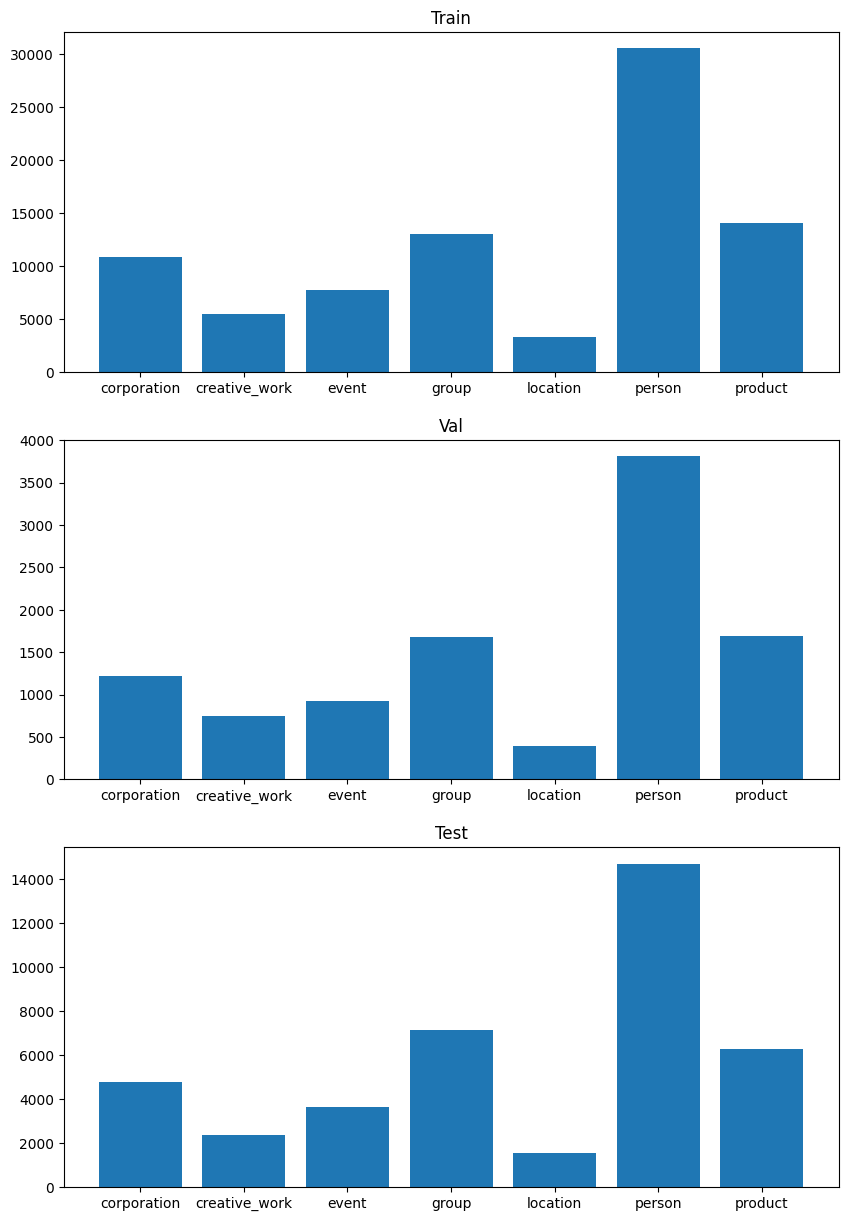

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

plot_categ_distribution(train_dataset_tokenized, axes[0], 'Train')
plot_categ_distribution(val_dataset_tokenized, axes[1], 'Val')
plot_categ_distribution(test_dataset_tokenized, axes[2], 'Test')

As we can see, distribution of categories imbalanced, but equal for all data subsets.

## BERT training

In [7]:
import evaluate

from backend.data_utils import create_dataset, DataCollator, NERDataset
from backend.model_utils import create_model
from backend.training_utils import Trainer

from transformers import AutoTokenizer, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW


torch.manual_seed(0)
save_path = './checkpoints/bert_base'

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = create_model(model_name, label_2_id)

train_ner_dataset = NERDataset(train_dataset_tokenized)
val_ner_dataset = NERDataset(val_dataset_tokenized)
test_ner_dataset = NERDataset(test_dataset_tokenized)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
collator = DataCollator(token_pad_id=tokenizer.pad_token_id)
train_dataloader = DataLoader(train_ner_dataset, batch_size=32, shuffle=True, collate_fn=collator, drop_last=True)
val_dataloader = DataLoader(val_ner_dataset, batch_size=64, shuffle=False, collate_fn=collator, drop_last=False)

In [10]:
lr = 1e-4
weight_decay = 1e-07
epochs = 30
warmup_steps =  0.3 * epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, epochs * len(train_dataloader))

trainer = Trainer(model, optimizer, train_dataloader, val_dataloader,
                  device=device, scheduler=scheduler)

losses = trainer.train(epochs, save_path)

Start training


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.60it/s]


Epoch: 0, Mean loss: 1.1777467089998832


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.61it/s]


Epoch: 1, Mean loss: 0.477963146862683


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.57it/s]


Epoch: 2, Mean loss: 0.38073252819411374


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.55it/s]


Epoch: 3, Mean loss: 0.3136813282161146


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.48it/s]


Epoch: 4, Mean loss: 0.2508383108688904


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.53it/s]


Epoch: 5, Mean loss: 0.198216737289955


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.56it/s]


Epoch: 6, Mean loss: 0.15814348212904764


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.50it/s]


Epoch: 7, Mean loss: 0.13177109607033902


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:30<00:00,  7.36it/s]


Epoch: 8, Mean loss: 0.11216027257745868


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:30<00:00,  7.35it/s]


Epoch: 9, Mean loss: 0.09123354635058761


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.51it/s]


Epoch: 10, Mean loss: 0.07402507334041439


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.51it/s]


Epoch: 11, Mean loss: 0.0568544716901473


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.52it/s]


Epoch: 12, Mean loss: 0.04529677431711604


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.52it/s]


Epoch: 13, Mean loss: 0.0369997055244607


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.57it/s]


Epoch: 14, Mean loss: 0.02877900145134074


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.52it/s]


Epoch: 15, Mean loss: 0.023239116930100768


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.53it/s]


Epoch: 16, Mean loss: 0.018706430398926197


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.52it/s]


Epoch: 17, Mean loss: 0.014855484468736552


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.49it/s]


Epoch: 18, Mean loss: 0.012208606078717349


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.43it/s]


Epoch: 19, Mean loss: 0.010586217392670195


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.54it/s]


Epoch: 20, Mean loss: 0.007866921659238087


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.49it/s]


Epoch: 21, Mean loss: 0.006581728890572824


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.50it/s]


Epoch: 22, Mean loss: 0.005300121211975413


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.46it/s]


Epoch: 23, Mean loss: 0.0038743619398037715


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.45it/s]


Epoch: 24, Mean loss: 0.002573825693698464


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.53it/s]


Epoch: 25, Mean loss: 0.0020115561445080052


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.54it/s]


Epoch: 26, Mean loss: 0.00187911032510267


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.51it/s]


Epoch: 27, Mean loss: 0.0014544180118169962


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.49it/s]


Epoch: 28, Mean loss: 0.0012053789661778758


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.52it/s]


Epoch: 29, Mean loss: 0.0008981851685209081


In [11]:
def calculate_metrics(predictions: list[str], labels: list[str]):
    metric = evaluate.load("seqeval")
    predictions_adj = [predictions[i] for i in range(len(predictions)) if len(predictions[i]) == len(labels[i])]
    labels_adj = [labels[i] for i in range(len(labels)) if len(predictions[i]) == len(labels[i])]
    metrics = metric.compute(predictions=list(predictions_adj), references=labels_adj)
    metrics_class = {k: metrics[k] for k in labels_list}
    metrics_global = {k: metrics[k] for k in global_metrics}
    print(pd.DataFrame(metrics_class), '\n')
    print(pd.DataFrame([metrics_global], columns=list(metrics_global.keys()), index=['Value']))

In [13]:
import os
from backend.validation_utils import inference


best_model = torch.load(os.path.join(save_path, 'best_model.pth'), weights_only=False).to(device).eval()
val_dataloader = DataLoader(val_ner_dataset, batch_size=1, shuffle=False, collate_fn=collator, drop_last=False)
model_preds = inference(best_model, val_dataloader, val_dataset_tokenized['word_inds'], {v: k for k, v in label_2_id.items()}, device=device)

calculate_metrics(model_preds, val_dataset['bio_labels'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 886/886 [00:02<00:00, 321.20it/s]


           corporation  creative_work       event       group    location  \
precision     0.498361       0.428571    0.394737    0.559551    0.576208   
recall        0.500000       0.446809    0.348837    0.548458    0.612648   
f1            0.499179       0.437500    0.370370    0.553949    0.593870   
number      304.000000     282.000000  387.000000  454.000000  253.000000   

               person     product  
precision    0.831002    0.637931  
recall       0.809308    0.632479  
f1           0.820012    0.635193  
number     881.000000  351.000000   

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.612373        0.601648    0.606963          0.908093
